In [60]:
## ALL IMPORTS FOR A NEW NOTEBOOK

import os, sys, random, math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn import model_selection as ms

import torch_utils
from tqdm.notebook import tqdm_notebook as tqdm
import time

In [61]:
torch_utils.seed_everything(947)

In [62]:
print ("ASDF")

ASDF


In [63]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

In [64]:
train_df.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,...,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,...,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,...,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [65]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 25 columns):
id        300000 non-null int64
bin_0     300000 non-null int64
bin_1     300000 non-null int64
bin_2     300000 non-null int64
bin_3     300000 non-null object
bin_4     300000 non-null object
nom_0     300000 non-null object
nom_1     300000 non-null object
nom_2     300000 non-null object
nom_3     300000 non-null object
nom_4     300000 non-null object
nom_5     300000 non-null object
nom_6     300000 non-null object
nom_7     300000 non-null object
nom_8     300000 non-null object
nom_9     300000 non-null object
ord_0     300000 non-null int64
ord_1     300000 non-null object
ord_2     300000 non-null object
ord_3     300000 non-null object
ord_4     300000 non-null object
ord_5     300000 non-null object
day       300000 non-null int64
month     300000 non-null int64
target    300000 non-null int64
dtypes: int64(8), object(17)
memory usage: 57.2+ MB


In [144]:
X = train_df.drop(["target"], axis=1)
y = train_df.target

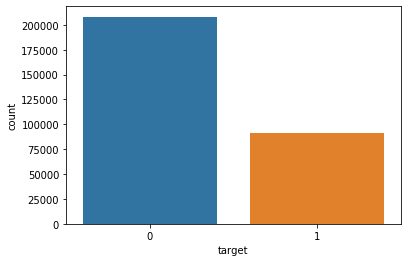

In [67]:
sns.countplot(y)

In [76]:
%%time
from sklearn.preprocessing import LabelEncoder

train = pd.DataFrame()
test = pd.DataFrame()
le = LabelEncoder()

for c in X.columns:
    if(X[c].dtype == "object"):
        train[c] = le.fit_transform(X[c])
        test[c] = le.transform(test_df[c])
    else:
        train[c] = X[c]
        test[c] = test_df[c]

train.head()

ValueError: y contains previously unseen labels: 'a9bf3dc47'

In [99]:
from sklearn.linear_model import LogisticRegression
def logistic(X, y, max_iter=1000):
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, random_state=947, test_size=0.2)
    lr = LogisticRegression(solver="lbfgs", max_iter=max_iter, verbose=1, n_jobs=5)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test, y_pred)
    
    print("Accuracy: {}\nAUC: {}".format(acc,auc))
    return lr

In [70]:
%%time
#Wall time: 11.6 s

logistic(train, y)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Accuracy: 0.6914666666666667
AUC: 0.528959647896165
CPU times: user 1.14 s, sys: 240 ms, total: 1.38 s
Wall time: 11.5 s


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.3s finished


In [78]:
ohe = pp.OneHotEncoder(handle_unknown="ignore")
ohe.fit(X)
train = ohe.transform(X)
test = ohe.transform(test_df)
print(X.shape)
print(train.shape)

(300000, 24)
(300000, 316461)


In [80]:
%%time
#Wall time: 1min 1s
model = logistic(train, y)
proba = model.predict_proba(test)
submission = pd.read_csv("./sample_submission.csv")
submission["target"] = pd.Series(proba[:,1])
submission.to_csv("Submit.csv", index=False)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Accuracy: 0.75925
AUC: 0.681289882471176
CPU times: user 284 ms, sys: 169 ms, total: 452 ms
Wall time: 1min 1s


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  1.0min finished


array([[0.72355248, 0.27644752],
       [0.33550749, 0.66449251],
       [0.92362295, 0.07637705],
       ...,
       [0.65773301, 0.34226699],
       [0.45909781, 0.54090219],
       [0.72816545, 0.27183455]])

In [97]:
%%time
#Wall time: 4.78 s

from sklearn.feature_extraction import FeatureHasher

X_train_hash = X.copy()
X_test_hash = test_df.copy()
for c in X.columns:
    X_train_hash[c] = X[c].astype("str")
    X_test_hash[c] = test_df[c].astype("str")

hashings = FeatureHasher(input_type="string")

train = hashings.transform(X_train_hash.values)
test = hashings.transform(X_test_hash.values)
print(train.shape)

(300000, 1048576)
CPU times: user 22.7 s, sys: 1.09 s, total: 23.8 s
Wall time: 7.78 s


In [100]:
%%time
#Wall time: 1min 1s
model = logistic(train, y, max_iter=5000)
proba = model.predict_proba(test)
submission = pd.read_csv("./sample_submission.csv")
submission["target"] = pd.Series(proba[:,1])
submission.to_csv("Submit.csv", index=False)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  2.5min finished


Accuracy: 0.7498666666666667
AUC: 0.6673055887025879
CPU times: user 1.9 s, sys: 203 ms, total: 2.1 s
Wall time: 2min 30s


In [105]:
%%time

X_train_stat = X.copy()
X_test_stat = test_df.copy()
for c in X_train_stat.columns:
    if X_train_stat[c].dtype == "object":
        X_train_stat[c] = X_train_stat[c].astype("category")
        X_test_stat[c] = X_test_stat[c].astype("category")
        
        counts = X_train_stat[c].value_counts()
        counts = counts.sort_index()
        counts = counts.fillna(0)
        counts+=np.random.rand(len(counts))/1000
        
        X_train_stat[c].cat.categories = counts
        
        counts = X_test_stat[c].value_counts()
        counts = counts.sort_index()
        counts = counts.fillna(0)
        counts+=np.random.rand(len(counts))/1000
        
        X_test_stat[c].cat.categories = counts

CPU times: user 2.71 s, sys: 111 ms, total: 2.82 s
Wall time: 1.45 s


In [106]:
X_train_stat.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,0,0,0,0,153535.000561,191633.000239,127341.000226,29855.000268,45979.000456,36942.000256,...,271.000054,19.000919,2,77428.000173,33768.000501,24740.000922,3974.000250,506.000194,2,2
1,1,0,1,0,153535.000561,191633.000239,127341.000226,101181.000103,29487.000978,101123.000149,...,111.000569,13.000371,1,77428.000173,22227.000243,35276.000828,18258.000436,2603.000231,7,8
2,2,0,0,0,146465.000952,191633.000239,96166.000248,101181.000103,101295.000414,101123.000149,...,278.000184,29.000154,1,25065.000740,63908.000401,24740.000922,16927.000625,2572.000930,7,2
3,3,0,1,0,146465.000952,191633.000239,76493.000502,101181.000103,45979.000456,49951.000916,...,203.000312,44.000096,1,77428.000173,60627.000689,28048.000064,3974.000250,2590.000008,2,1
4,4,0,0,0,146465.000952,108367.000324,76493.000502,101181.000103,101295.000414,49951.000916,...,207.000983,35.000041,1,77428.000173,99816.000282,35276.000828,16927.000625,2854.000652,7,8


In [110]:
%%time
#Wall time: 1min 1s
model = logistic(X_train_stat, y, max_iter=5000)
proba = model.predict_proba(X_test_stat)
submission = pd.read_csv("./sample_submission.csv")
submission["target"] = pd.Series(proba[:,1])
submission.to_csv("Submit.csv", index=False)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    5.2s finished


Accuracy: 0.6945333333333333
AUC: 0.49998800182372277
CPU times: user 2.17 s, sys: 251 ms, total: 2.42 s
Wall time: 6.56 s


In [156]:
X_train_cyc = train_df.drop(["target"], axis=1)
X_test_cyc = test_df.copy()
columns = ["day", "month"]

for col in columns:
    X_train_cyc[col+"sin"] = np.sin((2*np.pi*X_train_cyc[col])/max(X_train_cyc[col]))
    X_test_cyc[col+"sin"] = np.sin((2*np.pi*X_test_cyc[col])/max(X_train_cyc[col]))
    X_train_cyc[col+"cos"] = np.cos((2*np.pi*X_train_cyc[col])/max(X_train_cyc[col]))
    X_test_cyc[col+"cos"] = np.cos((2*np.pi*X_test_cyc[col])/max(X_train_cyc[col]))

X_train_cyc = X_train_cyc.drop(columns, axis=1)
X_test_cyc = X_test_cyc.drop(columns, axis=1)

In [157]:
ohe = pp.OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train_cyc)
train = ohe.fit_transform(X_train_cyc)

In [158]:
test = ohe.transform(X_test_cyc)

In [159]:
model = logistic(train, y)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Accuracy: 0.7592666666666666
AUC: 0.681332448598931


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  1.1min finished


In [161]:
proba = model.predict_proba(test)
submission = pd.read_csv("./sample_submission.csv")
submission["target"] = pd.Series(proba[:,1])
submission.to_csv("Submit.csv", index=False)

In [167]:
%%time
X_target = train_df.copy()
test = test_df.copy()
X_target['day'] = X_target["day"].astype("object")
X_target['month'] = X_target["month"].astype("object")

for col in X_target.columns:
    print("Encoding: {}".format(col))
    if (X_target[col].dtype == "object"):
        target = dict(X_target.groupby(col)["target"].agg("sum")/X_target.groupby(col)['target'].agg("count"))
        X_target[col] = X_target[col].replace(target).values
        test[col] = test[col].replace(target).values

Encoding: id
Encoding: bin_0
Encoding: bin_1
Encoding: bin_2
Encoding: bin_3
Encoding: bin_4
Encoding: nom_0
Encoding: nom_1
Encoding: nom_2
Encoding: nom_3
Encoding: nom_4
Encoding: nom_5
Encoding: nom_6
Encoding: nom_7
Encoding: nom_8
Encoding: nom_9
Encoding: ord_0
Encoding: ord_1
Encoding: ord_2
Encoding: ord_3
Encoding: ord_4
Encoding: ord_5
Encoding: day
Encoding: month
Encoding: target
CPU times: user 4min 28s, sys: 3.13 s, total: 4min 31s
Wall time: 4min 1s


In [169]:
model = logistic(X_target.drop("target", axis=1), y)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Accuracy: 0.69455
AUC: 0.5


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    1.1s finished


In [170]:
proba = model.predict_proba(test)
submission = pd.read_csv("./sample_submission.csv")
submission["target"] = pd.Series(proba[:,1])
submission.to_csv("Submit.csv", index=False)

ValueError: could not convert string to float: 'a9bf3dc47'